# **Install Packages**

In [ ]:
!pip install opendatasets
!pip install tpot
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11937 sha256=308caac6b543d38ea9318b4f3fd9842babfb10357524cd4f5701128a9719a048
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


# **Import Libraries**

In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize
from math import ceil
from imblearn.over_sampling import SMOTENC
from sklearn.neighbors import LocalOutlierFactor

# **Read Dataset**

In [ ]:
od.download("https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset?select=train_u6lujuX_CVtuZ9i.csv")

100%|██████████| 12.6k/12.6k [00:00<00:00, 19.4MB/s]

In [ ]:
df= pd.read_csv("/content/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv")

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# **Dataset Analysis & Pre-processing**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Checking for NULL values**

In [ ]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

✅ We can spot null values that are needed to handle properly

**Checking for duplicate values**

In [ ]:
duplicateValue = df.duplicated()

In [ ]:
print(duplicateValue.sum())

0


✅ No duplicate values found

**Remove unnecessary column**

In [ ]:
# Remove 'Loan_ID' column
df = df.drop(columns=['Loan_ID'])

**Check for unique values in categorical columns**

In [ ]:
# Check unique values for each categorical column

cat_cols= ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

for column in cat_cols:
    unique_values = df[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")

Unique values for column 'Gender': ['Male' 'Female' nan]
Unique values for column 'Married': ['No' 'Yes' nan]
Unique values for column 'Dependents': ['0' '1' '2' '3+' nan]
Unique values for column 'Education': ['Graduate' 'Not Graduate']
Unique values for column 'Self_Employed': ['No' 'Yes' nan]
Unique values for column 'Credit_History': [ 1.  0. nan]
Unique values for column 'Property_Area': ['Urban' 'Rural' 'Semiurban']


🔖🔖 Here we can spot nan as category. However, after removing null values, it won't exist. Still, there are some cases to handle:

▶ In the **Dependents** column, we can spot a category as **3+** which is not acceptable. It is needed to be handled.

▶ In the **Credit_History** column, the entries are given as float data type. This needs to be fixed by converting into int datatype.

**Handle NULL values of categorical Columns**

⭐ Filling the null values with the most frequent value of it's respective column

In [ ]:
cat_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']

for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

**Converting data type**

In [ ]:
# Convert the 'Credit_History' column to int data type
df['Credit_History'] = df['Credit_History'].astype('int')

**Handle Dependents Column**

In [ ]:
le = LabelEncoder()

In [ ]:
df['Dependents'] = le.fit_transform(df['Dependents'])

In [ ]:
for column in cat_cols:
    unique_values = df[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")

Unique values for column 'Gender': ['Male' 'Female']
Unique values for column 'Married': ['No' 'Yes']
Unique values for column 'Dependents': [0 1 2 3]
Unique values for column 'Self_Employed': ['No' 'Yes']
Unique values for column 'Credit_History': [1 0]


**Handle Null values of Numeric Columns**

In [ ]:
# Select numerical columns for KNN imputation
numerical_cols = ['LoanAmount', 'Loan_Amount_Term']


In [ ]:
# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
df[numerical_cols] = knn_imputer.fit_transform(df[numerical_cols])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    int64  
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    int64  
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 57.7+ KB


# **Outlier Detection**

**For Categorical Columns**

In [ ]:
# Select the features for outlier detection
selected_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

✅ We will be detecting outliers using two methods:



▶ Using Box Plots

▶ Using Isolation Forest Method

**Box Plot**

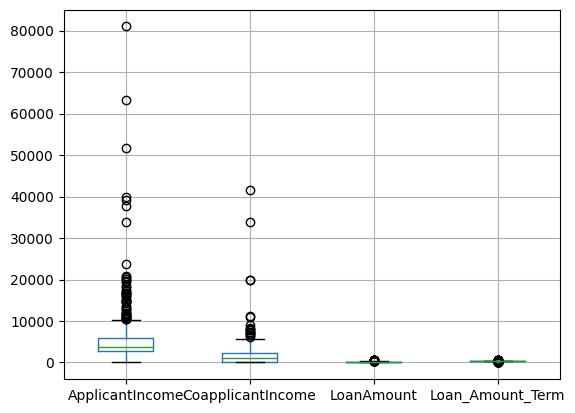

In [ ]:
df[selected_features].boxplot()
plt.show()

👉 In this box plot, outliers are visible

**Isolation Forest**

In [ ]:
X = df[selected_features].values

In [ ]:
# Fit the Isolation Forest model
clf = IsolationForest(contamination='auto')  # Adjust the contamination parameter based on your dataset
clf.fit(X)

IsolationForest()

In [ ]:
# Predict outliers
# -1 represents outliers and 1 represents inliers.
df['Outlier'] = clf.predict(X)

In [ ]:
df['Outlier'].unique()

array([ 1, -1])

<ipython-input-26-4a2e08badf98>:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df[feature], df['Outlier'], label=feature, cmap='viridis', alpha=0.7)


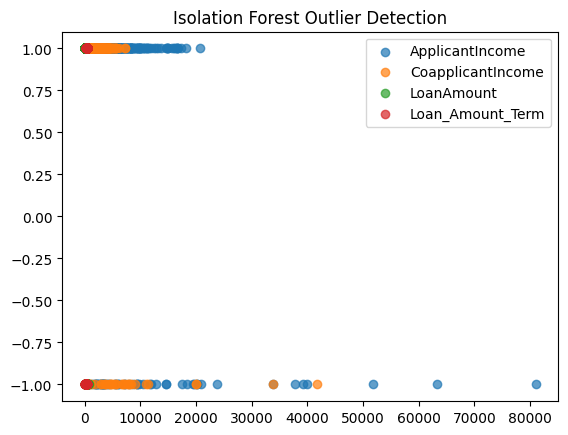

In [ ]:
# Plot the results
for feature in selected_features:
    plt.scatter(df[feature], df['Outlier'], label=feature, cmap='viridis', alpha=0.7)

plt.title('Isolation Forest Outlier Detection')
plt.legend()
plt.show()


⚡ In this method, outliers are detected as -1. And, we can spot outliers from all the categorical columns with a heavy density.

**Counting the total no of outliers present in the dataset**

In [ ]:
num_outliers = (df['Outlier'] == -1).sum()

print(f"Number of outliers (-1): {num_outliers}")

Number of outliers (-1): 57


**Pair Plot for Outlier Detection**

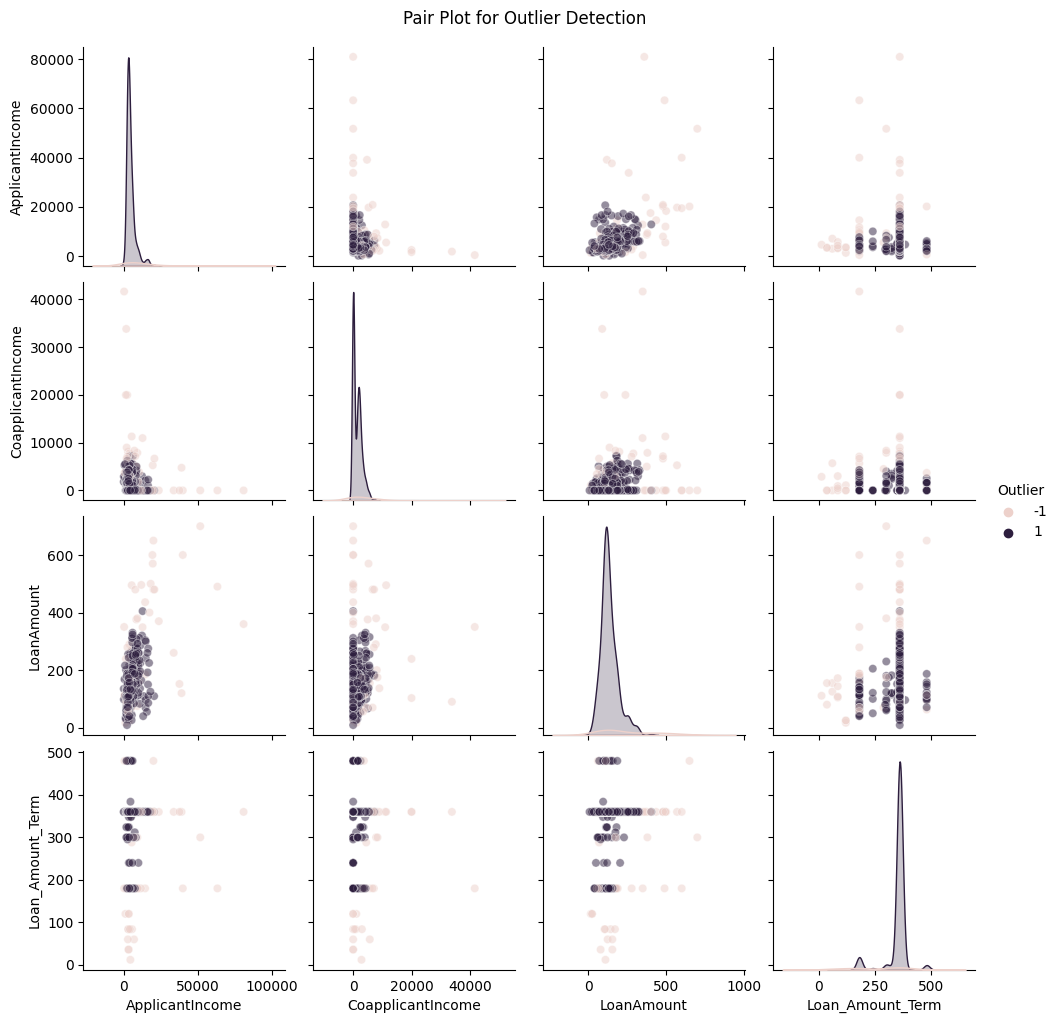

In [ ]:
sns.pairplot(df, hue='Outlier', vars=selected_features, plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot for Outlier Detection', y=1.02)
plt.show()


🔯 Here, every plot shows a vast amount of outliers

**Heatmap of the Categorical Columns**

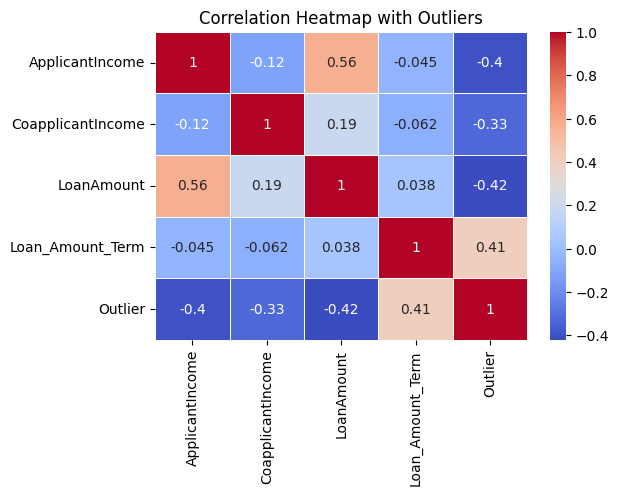

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(df[selected_features + ['Outlier']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap with Outliers')
plt.show()


# **Removing Outliers**

In [ ]:
# Remove rows with outliers
df_no_outliers = df[df['Outlier'] == 1].copy()

In [ ]:
# Drop the 'Outlier' column
df_no_outliers = df_no_outliers.drop(columns=['Outlier'])

In [ ]:
df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             557 non-null    object 
 1   Married            557 non-null    object 
 2   Dependents         557 non-null    int64  
 3   Education          557 non-null    object 
 4   Self_Employed      557 non-null    object 
 5   ApplicantIncome    557 non-null    int64  
 6   CoapplicantIncome  557 non-null    float64
 7   LoanAmount         557 non-null    float64
 8   Loan_Amount_Term   557 non-null    float64
 9   Credit_History     557 non-null    int64  
 10  Property_Area      557 non-null    object 
 11  Loan_Status        557 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 56.6+ KB


# **EDA**

**Count Plot for Categorical Columns**

In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents',
                       'Education', 'Self_Employed', 'Credit_History',
                       'Property_Area', 'Loan_Status']

In [ ]:
def plot_categorical_histograms(df, categorical_columns):
    num_columns = len(categorical_columns)
    num_rows = ceil(num_columns / 3)

    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 4 * num_rows))

    for i, column in enumerate(categorical_columns):
        row_index = i // 3
        col_index = i % 3
        ax = axes[row_index, col_index]

        sns.countplot(x=column, data=df_no_outliers, palette='viridis', ax=ax)
        ax.set_title(f'Count Plot for {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')

    # Remove empty subplots in the last row if there are fewer than 3 columns
    for i in range(num_columns, num_rows * 3):
        fig.delaxes(axes.flatten()[i])

    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()
    plt.show()

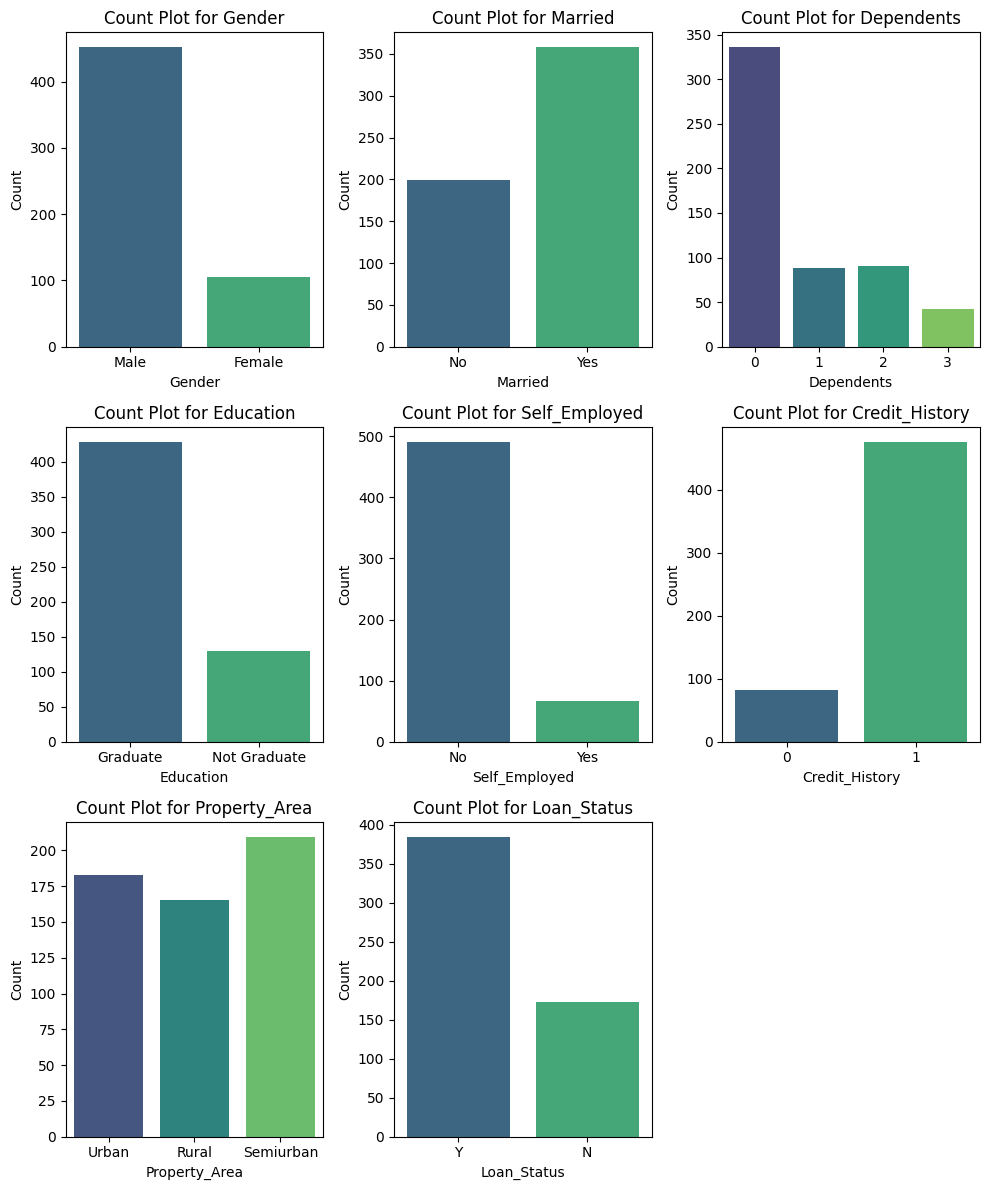

In [ ]:
# Plot count plots for categorical variables
plot_categorical_histograms(df_no_outliers, categorical_columns)

✍ In this dataset, more datas are collected from Male. That implies that male are most likely to request for a loan.

✍ Unmarried people count is less than Married people count. In is sensible to think that people who are married tend to apply for loan more.

✍ Most people who apply for loan don't have any dependencies.

✍ Graduate people apply for loan often.

✍ Self employed poeple tend to avoid taking loan.

✍ People who are used to the credit system, tend to take loan.

✍ People from all kind of area seems to have mentality to take loans

**Distribution of Loan_Status based on categorical variables**

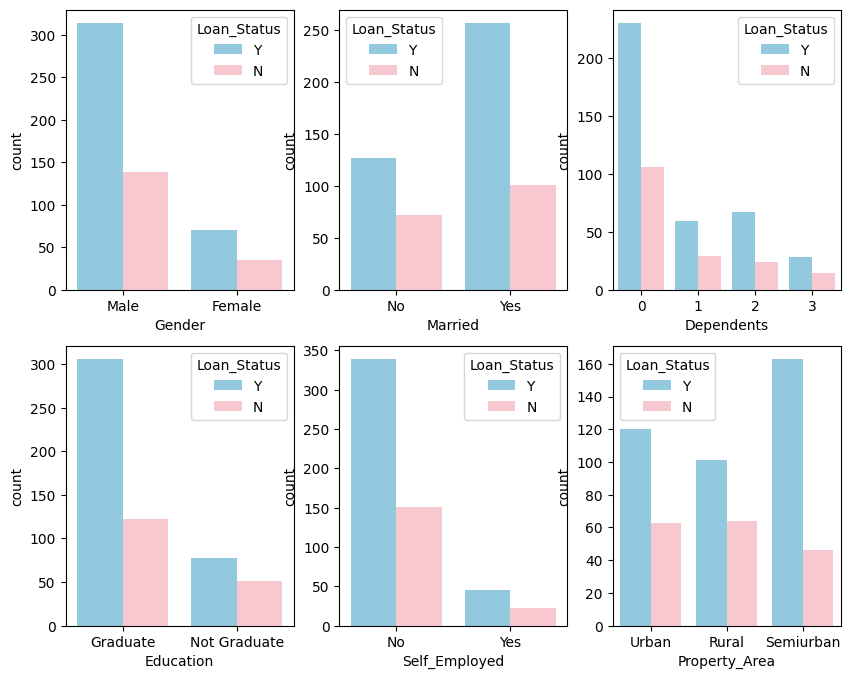

In [ ]:
# Explore distribution of Loan_Status based on categorical variables
fig, axes = plt.subplots(2, 3, figsize=(10,8))

categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Define a custom color palette
custom_palette = {'Y': 'skyblue', 'N': 'pink'}

for i, var in enumerate(categorical_vars):
    row, col = i // 3, i % 3
    sns.countplot(x=var, hue='Loan_Status', data= df_no_outliers, ax=axes[row, col], palette=custom_palette)

plt.show()


**Distribution of Applicant Income and Coapplicant Income**

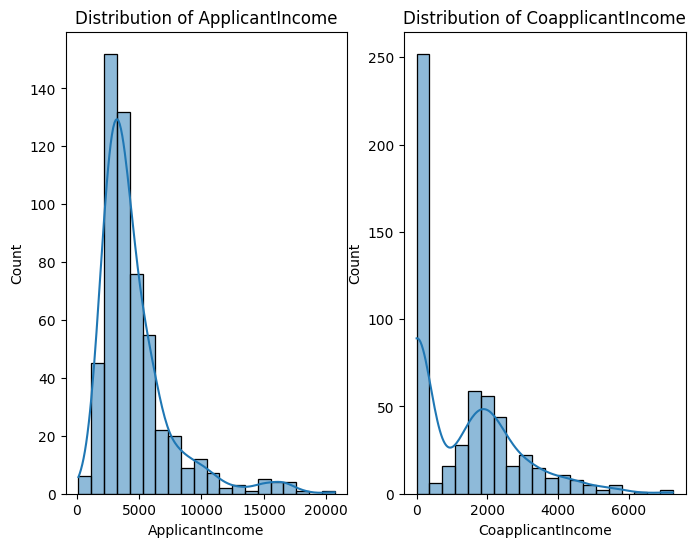

In [ ]:

# Explore distribution of ApplicantIncome and CoapplicantIncome
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.histplot(df_no_outliers['ApplicantIncome'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of ApplicantIncome')

sns.histplot(df_no_outliers['CoapplicantIncome'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of CoapplicantIncome')

plt.show()

🔃 Most people who apply for loan have income in between 3000 to 6000

🔃 Max coapplicants do not have much income

**Relationship between Credit History and Loan Approval**

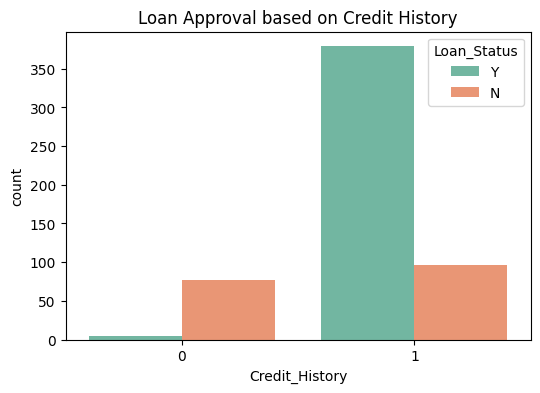

In [ ]:
# Explore relationship between Credit_History and loan approval
plt.figure(figsize=(6,4))
sns.countplot(x='Credit_History', hue='Loan_Status', data=df_no_outliers, palette= 'Set2')
plt.title('Loan Approval based on Credit History')
plt.show()

💡 People with credit history tend to get more loan approvals

**Relationship between Income, Coapplicant Income, Loan Amount and Loan Status**

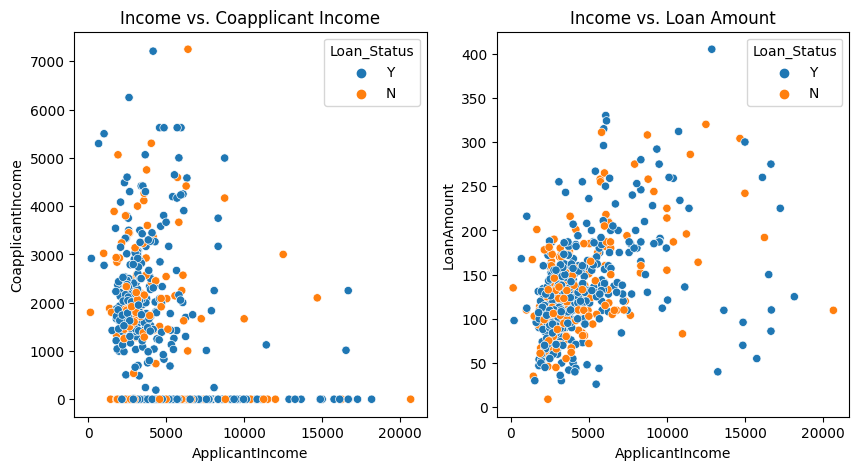

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Explore the relationship between income and coapplicant income
sns.scatterplot(x='ApplicantIncome', y='CoapplicantIncome', hue='Loan_Status', data=df_no_outliers, ax=axes[0])
axes[0].set_title('Income vs. Coapplicant Income')

# Explore the relationship between loan amount and loan status
sns.scatterplot(x='ApplicantIncome', y='LoanAmount', hue='Loan_Status', data=df_no_outliers, ax=axes[1])
axes[1].set_title('Income vs. Loan Amount')

plt.show()


# **Feature Engineering**

🌟 Create a new column **Total Income** by adding two columns **Applicant Income** and **Coapplicant Income**

In [ ]:
# Create the 'Total_Income' column
df_no_outliers['Total_Income'] = df_no_outliers['ApplicantIncome'] + df_no_outliers['CoapplicantIncome']


**Analyze Total Income with Loan**

<ipython-input-41-ded1cc3cba8b>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Total_Income', y='Loan_Status',  data=df_no_outliers, palette='viridis', marker='o', ax=axes[1])
<ipython-input-41-ded1cc3cba8b>:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='LoanAmount', y='Loan_Status', data=df_no_outliers, palette='viridis', marker='o', ax=axes[2])


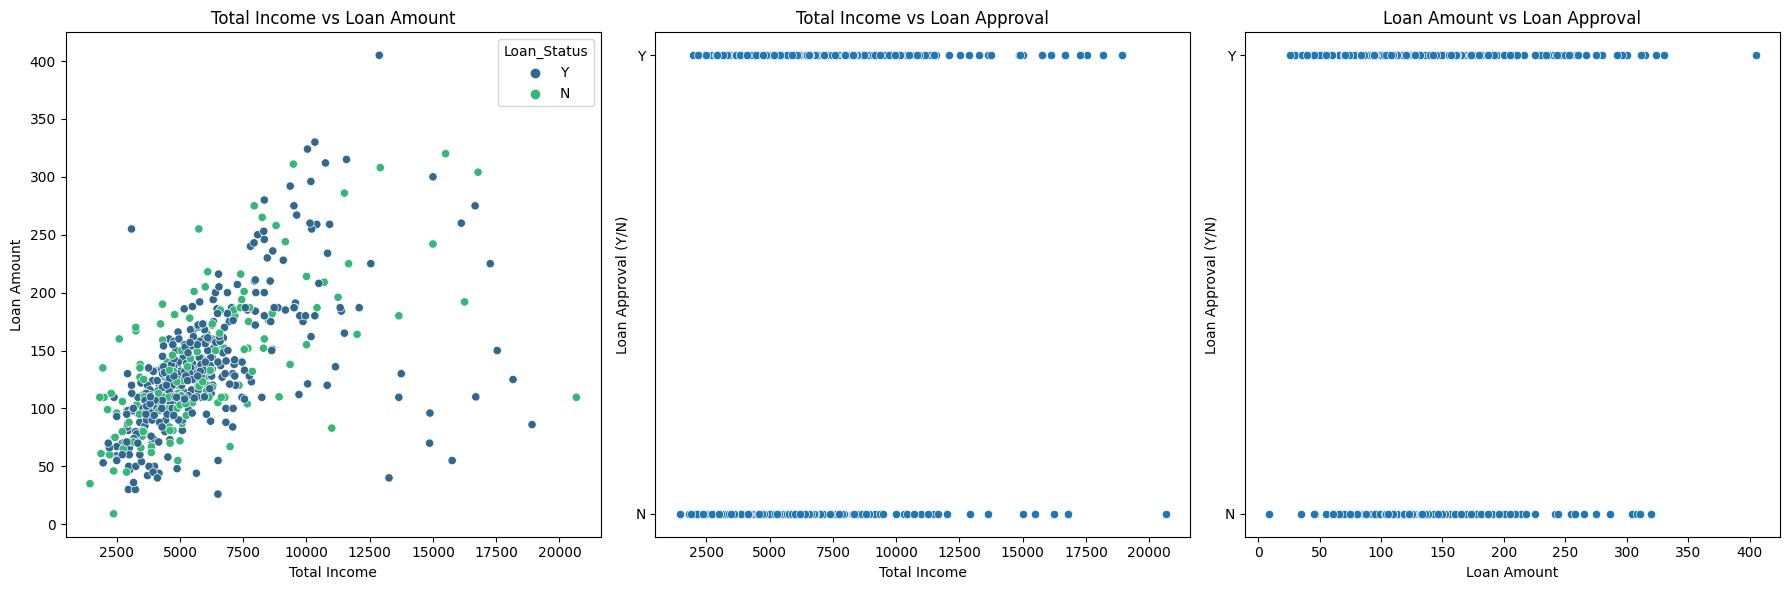

In [ ]:
# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot: Total Income vs Loan Amount
sns.scatterplot(x='Total_Income', y='LoanAmount', hue='Loan_Status', data=df_no_outliers, palette='viridis', ax=axes[0])
axes[0].set_title('Total Income vs Loan Amount')
axes[0].set_xlabel('Total Income')
axes[0].set_ylabel('Loan Amount')

# Scatter plot: Total Income vs Loan Approval
sns.scatterplot(x='Total_Income', y='Loan_Status',  data=df_no_outliers, palette='viridis', marker='o', ax=axes[1])
axes[1].set_title('Total Income vs Loan Approval')
axes[1].set_xlabel('Total Income')
axes[1].set_ylabel('Loan Approval (Y/N)')

# Scatter plot: Loan Amount vs Loan Approval
sns.scatterplot(x='LoanAmount', y='Loan_Status', data=df_no_outliers, palette='viridis', marker='o', ax=axes[2])
axes[2].set_title('Loan Amount vs Loan Approval')
axes[2].set_xlabel('Loan Amount')
axes[2].set_ylabel('Loan Approval (Y/N)')

# Adjust layout
plt.tight_layout()
plt.show()

**Credit history impact on loan approval rates**

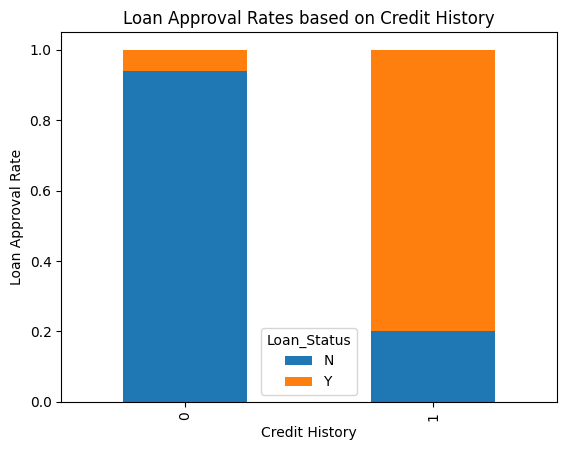

In [ ]:
# Credit history impact on loan approval rates
credit_history_approval = df_no_outliers.groupby('Credit_History')['Loan_Status'].value_counts(normalize=True).unstack()
credit_history_approval.plot(kind='bar', stacked=True)
plt.title('Loan Approval Rates based on Credit History')
plt.xlabel('Credit History')
plt.ylabel('Loan Approval Rate')
plt.show()

**Pairplot of Numerical Variables**

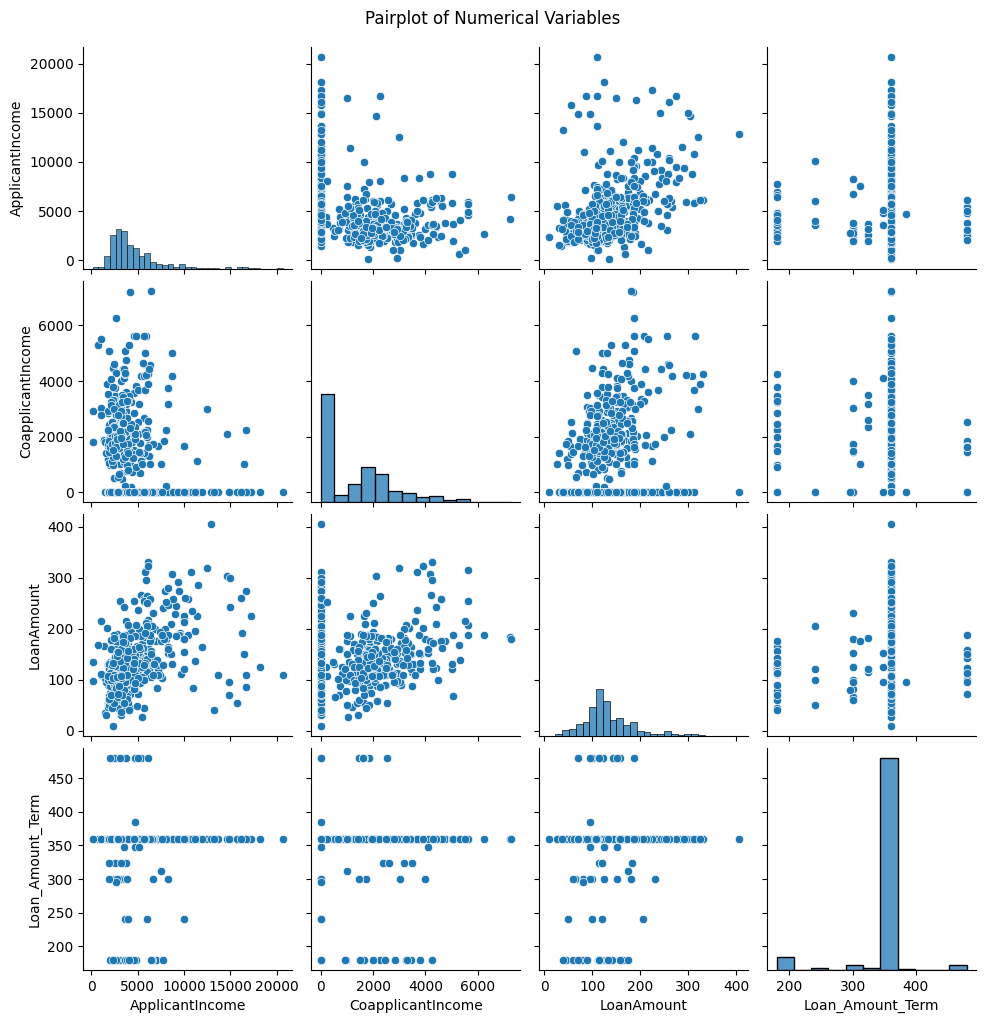

In [ ]:
sns.pairplot(df_no_outliers[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']])
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()


**Label encoding of Categorical Columns**

In [ ]:
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for column in categorical_columns:
    df_no_outliers[column] = le.fit_transform(df_no_outliers[column])


# **Split data into Training and Testing**

In [ ]:
X = df_no_outliers.drop(columns=['Loan_Status'])
y = df_no_outliers['Loan_Status']

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **Use TPOT Classifier**

In [ ]:
# Create and fit the TPOTClassifier
tpot = TPOTClassifier(verbosity=2, generations=50, population_size=100, random_state=42, scoring='accuracy', cv=10, n_jobs=-1)
tpot.fit(X_train, y_train)


Optimization Progress:   0%|          | 0/5100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8177777777777777

Generation 2 - Current best internal CV score: 0.8223737373737375

Generation 3 - Current best internal CV score: 0.8223737373737375

Generation 4 - Current best internal CV score: 0.8223737373737375

Generation 5 - Current best internal CV score: 0.8223737373737375

Generation 6 - Current best internal CV score: 0.8223737373737375

Generation 7 - Current best internal CV score: 0.8223737373737375

Generation 8 - Current best internal CV score: 0.8245959595959598

Generation 9 - Current best internal CV score: 0.8245959595959598

Generation 10 - Current best internal CV score: 0.8270707070707072

Generation 11 - Current best internal CV score: 0.8270707070707072

Generation 12 - Current best internal CV score: 0.8270707070707072

Generation 13 - Current best internal CV score: 0.8270707070707072

Generation 14 - Current best internal CV score: 0.8270707070707072

Generation 15 - Current best internal CV score: 0.827070

**Get the best pipeline and its accuracy on Test Data**

In [ ]:
# Get the best pipeline and its accuracy
best_pipeline = tpot.fitted_pipeline_
accuracy = best_pipeline.score(X_test, y_test)
print(f'Test set accuracy using the best pipeline: {accuracy}')

Test set accuracy using the best pipeline: 0.8303571428571429


**Steps of the pipeline**

In [ ]:
# Access the steps of the pipeline
steps = best_pipeline.steps

# Print the names of all steps in the pipeline
for step_name, step_object in steps:
    print(step_name)

normalizer
selectpercentile
maxabsscaler
randomforestclassifier


**Feature Importance**

In [ ]:
# Access feature importances if the classifier supports it
if hasattr(best_pipeline.named_steps['randomforestclassifier'], 'feature_importances_'):
    feature_importances = best_pipeline.named_steps['randomforestclassifier'].feature_importances_
    # Print or use feature importances as needed
    print("Feature Importances:")
    print(feature_importances)
else:
    print("The classifier in the best pipeline does not support feature importances.")

Feature Importances:
[0.0330314  0.10580534 0.05712464 0.11391793 0.58335841 0.10676228]


In [ ]:
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
print("Feature Importances:")
for feature, importance in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance}")


Feature Importances:
Self_Employed: 0.583358410005103
Education: 0.11391793045676044
ApplicantIncome: 0.10676228324755212
Married: 0.10580533702883607
Dependents: 0.05712463724336725
Gender: 0.033031402018381235


💡 **We can see that whether the applicant is self employed or not keeps a significant effect on deciding the loan approval**

